In [1]:
import pandas as pd

# Load the datasets
train = pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e7/test.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e7/sample_submission.csv")

train.info()
train.head()
train.isnull().sum()
train['Personality'].value_counts()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18524 entries, 0 to 18523
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         18524 non-null  int64  
 1   Time_spent_Alone           17334 non-null  float64
 2   Stage_fear                 16631 non-null  object 
 3   Social_event_attendance    17344 non-null  float64
 4   Going_outside              17058 non-null  float64
 5   Drained_after_socializing  17375 non-null  object 
 6   Friends_circle_size        17470 non-null  float64
 7   Post_frequency             17260 non-null  float64
 8   Personality                18524 non-null  object 
dtypes: float64(5), int64(1), object(3)
memory usage: 1.3+ MB


Personality
Extrovert    13699
Introvert     4825
Name: count, dtype: int64

In [2]:
print("Stage_fear mode:", train['Stage_fear'].mode())
print("Drained_after_socializing mode:", train['Drained_after_socializing'].mode())




Stage_fear mode: 0    No
Name: Stage_fear, dtype: object
Drained_after_socializing mode: 0    No
Name: Drained_after_socializing, dtype: object


In [3]:
import pandas as pd

# Reload the original dataset
train = pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e7/test.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e7/sample_submission.csv")


# Step 1: Handle categorical columns BEFORE they get mapped or corrupted
# Impute with mode
stage_fear_mode = train.loc[train['Stage_fear'].notna(), 'Stage_fear'].mode()[0]
drained_mode = train.loc[train['Drained_after_socializing'].notna(), 'Drained_after_socializing'].mode()[0]

train['Stage_fear'] = train['Stage_fear'].fillna(stage_fear_mode)
train['Drained_after_socializing'] = train['Drained_after_socializing'].fillna(drained_mode)

# Encode 'Yes'/'No' to 1/0
train['Stage_fear'] = train['Stage_fear'].map({'Yes': 1, 'No': 0})
train['Drained_after_socializing'] = train['Drained_after_socializing'].map({'Yes': 1, 'No': 0})

# Step 2: Fill numeric columns
numeric_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
for col in numeric_cols:
    train[col] = train[col].fillna(train[col].median())

# Step 3: Encode target
train['Personality'] = train['Personality'].map({'Introvert': 0, 'Extrovert': 1})

# ✅ Sanity check
train.isnull().sum()


id                           0
Time_spent_Alone             0
Stage_fear                   0
Social_event_attendance      0
Going_outside                0
Drained_after_socializing    0
Friends_circle_size          0
Post_frequency               0
Personality                  0
dtype: int64

In [4]:
from sklearn.model_selection import train_test_split

# Drop ID column (not useful for training)
X = train.drop(['id', 'Personality'], axis=1)
y = train['Personality']

# 80-20 split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Check shape
X_train.shape, X_val.shape


((14819, 7), (3705, 7))

In [5]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Identify categorical columns
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# One-hot encoder for categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Leave numeric columns as is
)

# Fit and transform the training data
X_train_encoded = preprocessor.fit_transform(X_train)
X_val_encoded = preprocessor.transform(X_val)

# Check shape
X_train_encoded.shape, X_val_encoded.shape


((14819, 7), (3705, 7))

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize the model
model = LogisticRegression(max_iter=1000, random_state=42)

# Train the model
model.fit(X_train_encoded, y_train)

# Predict on validation set
y_pred = model.predict(X_val_encoded)

# Evaluate the model
print("Accuracy:", accuracy_score(y_val, y_pred))
print("\nClassification Report:\n", classification_report(y_val, y_pred))


Accuracy: 0.9651821862348178

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       965
           1       0.97      0.98      0.98      2740

    accuracy                           0.97      3705
   macro avg       0.96      0.95      0.95      3705
weighted avg       0.97      0.97      0.97      3705



In [7]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# --- 1. Load Data ---
print("Loading data...")
train = pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv")
test = pd.read_csv(("/kaggle/input/playground-series-s5e7/test.csv"))
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e7/sample_submission.csv") # Load for format reference if needed

# --- 2. Prepare Training Data ---
print("Preparing training data...")
# Define feature columns and target column
feature_columns = ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
                   'Going_outside', 'Drained_after_socializing',
                   'Friends_circle_size', 'Post_frequency']
target_column = 'Personality'

# Handle missing values in categorical features in TRAINING data
# Fill with a placeholder 'Missing' to represent unknown categories consistently
train['Stage_fear'] = train['Stage_fear'].fillna('Missing')
train['Drained_after_socializing'] = train['Drained_after_socializing'].fillna('Missing')

# Initialize Label Encoders for categorical features and target
le_stage = LabelEncoder()
le_drained = LabelEncoder()
le_personality = LabelEncoder()

# Fit Encoders on TRAINING data categories
le_stage.fit(train['Stage_fear'])
le_drained.fit(train['Drained_after_socializing'])
# Fit target encoder. Ensure classes are consistent (e.g., ['Extrovert', 'Introvert'])
le_personality.fit(train[target_column])

# Encode TRAINING data
train_encoded = train.copy()
train_encoded['Stage_fear'] = le_stage.transform(train_encoded['Stage_fear'])
train_encoded['Drained_after_socializing'] = le_drained.transform(train_encoded['Drained_after_socializing'])
train_encoded[target_column] = le_personality.transform(train_encoded[target_column])

# Select features and target for training
X_train = train_encoded[feature_columns]
y_train = train_encoded[target_column]

# --- 3. Train XGBoost Model ---
print("Training XGBoost model...")
# XGBoost can handle NaN values natively in features
# Adjust hyperparameters as needed (e.g., n_estimators, max_depth, learning_rate)
model = XGBClassifier(
    n_estimators=200,      # Number of trees (try increasing if needed)
    max_depth=6,           # Maximum depth of a tree
    learning_rate=0.1,     # Step size shrinkage
    subsample=0.8,         # Subsample ratio of the training instances
    colsample_bytree=0.8,  # Subsample ratio of columns when constructing each tree
    random_state=42        # For reproducibility
)

# Fit the model directly on the data with potential NaNs in numerical features
model.fit(X_train, y_train)
print("Model training complete.")

# --- 4. Prepare Test Data ---
print("Preparing test data...")
# Handle missing values in categorical features in TEST data
# Use the same placeholder for consistency.
test['Stage_fear'] = test['Stage_fear'].fillna('Missing')
test['Drained_after_socializing'] = test['Drained_after_socializing'].fillna('Missing')

# Encode TEST data using the fitted encoders
test_encoded = test.copy()

# --- Safer Transformation for Test Categoricals ---
# Handle potential unseen labels in test set for Stage_fear
def safe_transform_stage(val):
    try:
        return le_stage.transform([val])[0]
    except ValueError:
        # If 'Missing' was in training classes, use its index; otherwise, default to 0
        try:
            missing_index = list(le_stage.classes_).index('Missing')
        except ValueError:
            missing_index = 0
        print(f"Warning: Unseen or missing label '{val}' in Stage_fear (Test), imputing as 'Missing'")
        return missing_index

# Handle potential unseen labels in test set for Drained_after_socializing
def safe_transform_drained(val):
    try:
        return le_drained.transform([val])[0]
    except ValueError:
        try:
            missing_index = list(le_drained.classes_).index('Missing')
        except ValueError:
            missing_index = 0
        print(f"Warning: Unseen or missing label '{val}' in Drained_after_socializing (Test), imputing as 'Missing'")
        return missing_index

# Apply safe transformations
test_encoded['Stage_fear'] = test_encoded['Stage_fear'].apply(safe_transform_stage)
test_encoded['Drained_after_socializing'] = test_encoded['Drained_after_socializing'].apply(safe_transform_drained)

# Select features for testing (this X_test can contain NaNs in numerical columns)
X_test = test_encoded[feature_columns]

# --- 5. Make Predictions ---
print("Making predictions...")
# XGBoost handles NaNs in X_test natively during prediction
test_predictions_encoded = model.predict(X_test) # Pass X_test directly

# --- 6. Decode Predictions ---
print("Decoding predictions...")
# Convert the numerical predictions back to original labels ('Introvert'/'Extrovert')
test_predictions_labels = le_personality.inverse_transform(test_predictions_encoded)

# --- 7. Create Submission File ---
print("Creating submission file...")
# Create the submission DataFrame using the test IDs and predicted labels
submission = pd.DataFrame({
    'id': test['id'],  # Use the 'id' column from the original test DataFrame
    'Personality': test_predictions_labels
})

# Save the submission to a CSV file
submission.to_csv('submission_xgboost.csv', index=False)
print("Submission file 'submission_xgboost.csv' created successfully.")

# Optional: Display first few rows
print("\nFirst 10 predictions:")
print(submission.head(10))


Loading data...
Preparing training data...
Training XGBoost model...
Model training complete.
Preparing test data...
Making predictions...
Decoding predictions...
Creating submission file...
Submission file 'submission_xgboost.csv' created successfully.

First 10 predictions:
      id Personality
0  18524   Extrovert
1  18525   Introvert
2  18526   Extrovert
3  18527   Extrovert
4  18528   Introvert
5  18529   Extrovert
6  18530   Extrovert
7  18531   Introvert
8  18532   Extrovert
9  18533   Introvert


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Split the original training data into training and validation sets
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train XGBoost model on the training portion
model.fit(X_tr, y_tr)

# Predict on validation set
val_preds = model.predict(X_val)

# Print classification report
print("Validation Classification Report:\n")
print(classification_report(y_val, val_preds, target_names=le_personality.classes_))


Validation Classification Report:

              precision    recall  f1-score   support

   Extrovert       0.98      0.98      0.98      2753
   Introvert       0.95      0.93      0.94       952

    accuracy                           0.97      3705
   macro avg       0.96      0.95      0.96      3705
weighted avg       0.97      0.97      0.97      3705



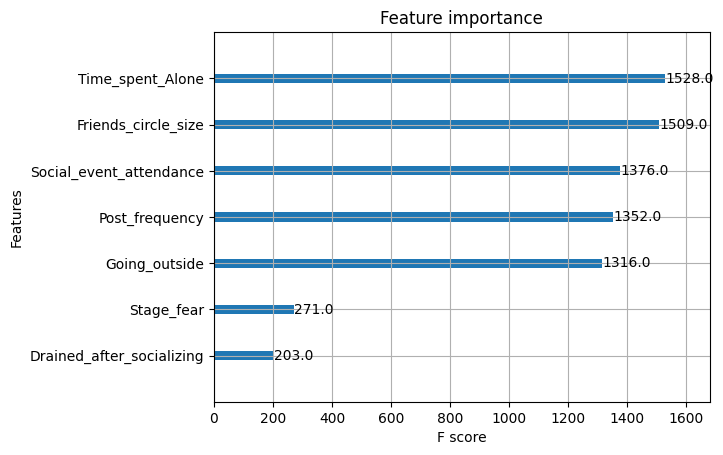

In [9]:
import matplotlib.pyplot as plt
from xgboost import plot_importance

plot_importance(model, max_num_features=10)
plt.show()


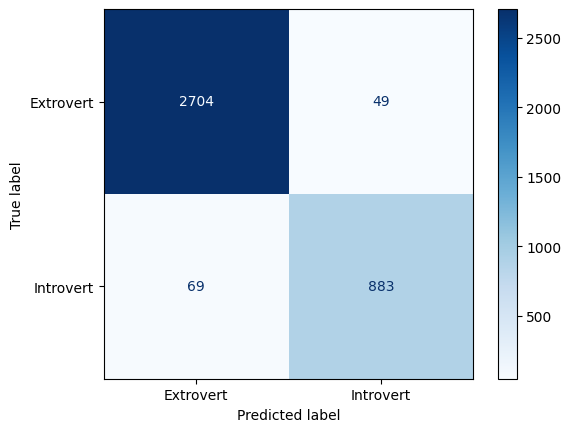

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_val, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le_personality.classes_)
disp.plot(cmap='Blues')
plt.show()


100%|===================| 6163/6175 [01:19<00:00]       

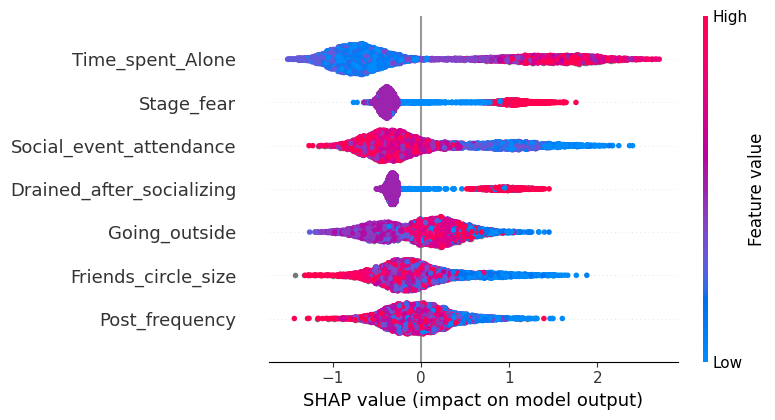

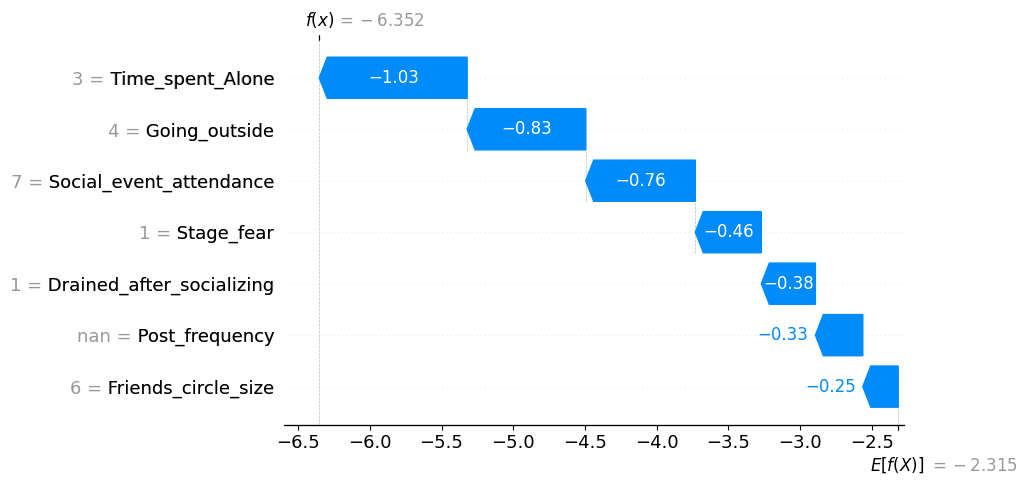

In [11]:
import shap

# Initialize SHAP explainer using the trained model and training data
explainer = shap.Explainer(model, X_train)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)

# Summary plot (shows global feature importance)
shap.summary_plot(shap_values, X_test)

# Waterfall plot for the first test instance (shows local explanation)
shap.plots.waterfall(shap_values[0])


In [12]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Example pipeline with imputation
numeric_features = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside',
                   'Friends_circle_size', 'Post_frequency']
categorical_features = ['Stage_fear', 'Drained_after_socializing']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('encoder', LabelEncoder()),
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Combine preprocessing with the model
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier())
])

In [13]:
print(train['Personality'].value_counts(normalize=True))

Personality
Extrovert    0.739527
Introvert    0.260473
Name: proportion, dtype: float64


In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder # Import LabelEncoder for target
from xgboost import XGBClassifier

# --- 1. Load Data ---
print("Loading data...")
# IMPORTANT: Please verify these paths are correct for your Kaggle notebook setup.
# They should match the exact file names and structure of the dataset you added.
# You can check the correct paths in the 'Data' panel on the right in your Kaggle notebook.
train = pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv") # Check path
test = pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv")   # Check path
# sample_submission = pd.read_csv("/kaggle/input/playground-series-s4e7/sample_submission.csv") # Check path (if needed)

# --- 2. Define Features (Excluding 'id' and 'Personality') ---
feature_columns = ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
                   'Going_outside', 'Drained_after_socializing',
                   'Friends_circle_size', 'Post_frequency']
target_column = 'Personality'
id_column = 'id' # Explicitly define the ID column

# --- 3. Prepare Data for Pipeline (X and y) ---
# Drop 'id' column as it's not a feature
X_full = train.drop([target_column, id_column], axis=1)
y_full = train[target_column]

# --- 4. Encode Target Labels (y) to Numerical ---
# This is necessary for XGBClassifier compatibility within cross_val_score Pipeline
le_target = LabelEncoder()
y_full_encoded = le_target.fit_transform(y_full)
print(f"Original target classes: {le_target.classes_}") # Should be ['Extrovert' 'Introvert'] or similar
print(f"Encoded target classes: {np.unique(y_full_encoded)}") # Should be [0 1] or similar

# --- 5. Define Preprocessing Steps ---
# Identify numerical and categorical columns
categorical_features = ['Stage_fear', 'Drained_after_socializing']
numerical_features = list(set(feature_columns) - set(categorical_features))

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Preprocessing for numerical features: Impute missing values with mean
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical features:
# 1. Impute missing values with a constant 'Missing'
# 2. Encode categories (strings) into integers using OrdinalEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Drop any columns not explicitly mentioned (like 'id')
)

# --- 6. Create the Full Pipeline (Preprocessing + Model) ---
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Combine preprocessing and model into a single pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# --- 7. Perform Cross-Validation ---
print("Performing cross-validation...")
try:
    # Use the ENCODED target variable y_full_encoded
    scores = cross_val_score(clf, X_full, y_full_encoded, cv=5, scoring='f1_macro', error_score='raise')
    print(f"Cross-validated F1 score (macro): {scores.mean():.4f} ± {scores.std():.4f}")
    print(f"Individual fold scores: {scores}")
except Exception as e:
    print(f"Error during cross-validation: {e}")
    print(f"Shape of X_full: {X_full.shape}")
    print(f"Shape of y_full_encoded: {y_full_encoded.shape}")
    print(f"Unique values in y_full_encoded: {np.unique(y_full_encoded)}")
    # Print first few rows of X_full for inspection if needed
    # print(X_full.head())
    raise e # Re-raise the exception to see the full traceback if needed


# --- 8. Train Final Model and Make Predictions (Optional, if CV is successful) ---

print("Training final model on full dataset...")
# Fit the pipeline on the full training data (using encoded y)
clf.fit(X_full, y_full_encoded) # Use encoded y for fitting

print("Making predictions on test set...")
# Prepare test data (drop 'id')
# Make sure to handle potential issues with column names or missing 'id' column gracefully
X_test_final = test.drop(columns=[id_column], errors='ignore') # Use columns parameter for clarity

# --- Add Check for Test Data Shape ---
print(f"Shape of original test data (test): {test.shape}")
print(f"Shape of test features for prediction (X_test_final): {X_test_final.shape}")
# It's crucial that X_test_final.shape[0] == 6175

# Predict using the pipeline (predictions will be numerical)
test_predictions_encoded = clf.predict(X_test_final)

# --- Add Check for Predictions Shape ---
print(f"Shape of test predictions (encoded): {test_predictions_encoded.shape}")
# It's crucial that test_predictions_encoded.shape[0] == 6175

# Decode predictions back to original labels
test_predictions_labels = le_target.inverse_transform(test_predictions_encoded)

print("Creating submission file...")
submission = pd.DataFrame({
    'id': test[id_column], # Use the 'id' column from the original test DataFrame
    'Personality': test_predictions_labels # Use decoded labels
})

# --- Add Final Check for Submission Shape ---
print(f"Shape of submission DataFrame: {submission.shape}")
# It's crucial that submission.shape[0] == 6175

# Save with the required filename
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created.")

Loading data...
Original target classes: ['Extrovert' 'Introvert']
Encoded target classes: [0 1]
Numerical features: ['Going_outside', 'Friends_circle_size', 'Post_frequency', 'Social_event_attendance', 'Time_spent_Alone']
Categorical features: ['Stage_fear', 'Drained_after_socializing']
Performing cross-validation...
Cross-validated F1 score (macro): 0.9591 ± 0.0044
Individual fold scores: [0.95978195 0.96206699 0.95277191 0.95586116 0.96516365]
Training final model on full dataset...
Making predictions on test set...
Shape of original test data (test): (18524, 9)
Shape of test features for prediction (X_test_final): (18524, 8)
Shape of test predictions (encoded): (18524,)
Creating submission file...
Shape of submission DataFrame: (18524, 2)
Submission file 'submission.csv' created.


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder # Import LabelEncoder for target
from xgboost import XGBClassifier

# --- 1. Load Data ---
print("Loading data...")
# IMPORTANT: Please verify these paths are correct for your Kaggle notebook setup.
# They should match the exact file names and structure of the dataset you added.
# You can check the correct paths in the 'Data' panel on the right in your Kaggle notebook.
train = pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv") # Check path
test = pd.read_csv("/kaggle/input/playground-series-s5e7/test.csv")   # Check path
# sample_submission = pd.read_csv("/kaggle/input/playground-series-s4e7/sample_submission.csv") # Check path (if needed)

# --- 2. Define Features (Excluding 'id' and 'Personality') ---
feature_columns = ['Time_spent_Alone', 'Stage_fear', 'Social_event_attendance',
                   'Going_outside', 'Drained_after_socializing',
                   'Friends_circle_size', 'Post_frequency']
target_column = 'Personality'
id_column = 'id' # Explicitly define the ID column

# --- 3. Prepare Data for Pipeline (X and y) ---
# Drop 'id' column as it's not a feature
X_full = train.drop([target_column, id_column], axis=1)
y_full = train[target_column]

# --- 4. Encode Target Labels (y) to Numerical ---
# This is necessary for XGBClassifier compatibility within cross_val_score Pipeline
le_target = LabelEncoder()
y_full_encoded = le_target.fit_transform(y_full)
print(f"Original target classes: {le_target.classes_}") # Should be ['Extrovert' 'Introvert'] or similar
print(f"Encoded target classes: {np.unique(y_full_encoded)}") # Should be [0 1] or similar

# --- 5. Define Preprocessing Steps ---
# Identify numerical and categorical columns
categorical_features = ['Stage_fear', 'Drained_after_socializing']
numerical_features = list(set(feature_columns) - set(categorical_features))

print(f"Numerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

# Preprocessing for numerical features: Impute missing values with mean
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical features:
# 1. Impute missing values with a constant 'Missing'
# 2. Encode categories (strings) into integers using OrdinalEncoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='drop' # Drop any columns not explicitly mentioned (like 'id')
)

# --- 6. Create the Full Pipeline (Preprocessing + Model) ---
model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Combine preprocessing and model into a single pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

# --- 7. Perform Cross-Validation ---
print("Performing cross-validation...")
try:
    # Use the ENCODED target variable y_full_encoded
    scores = cross_val_score(clf, X_full, y_full_encoded, cv=5, scoring='f1_macro', error_score='raise')
    print(f"Cross-validated F1 score (macro): {scores.mean():.4f} ± {scores.std():.4f}")
    print(f"Individual fold scores: {scores}")
except Exception as e:
    print(f"Error during cross-validation: {e}")
    print(f"Shape of X_full: {X_full.shape}")
    print(f"Shape of y_full_encoded: {y_full_encoded.shape}")
    print(f"Unique values in y_full_encoded: {np.unique(y_full_encoded)}")
    # Print first few rows of X_full for inspection if needed
    # print(X_full.head())
    raise e # Re-raise the exception to see the full traceback if needed


# --- 8. Train Final Model and Make Predictions (Optional, if CV is successful) ---
# Make sure these lines start at the leftmost edge (no leading spaces relative to the cell)
# or are consistently indented if they are meant to be inside another block (unlikely here).

print("Training final model on full dataset...")
# Fit the pipeline on the full training data (using encoded y)
clf.fit(X_full, y_full_encoded) # Use encoded y for fitting

print("Making predictions on test set...")
# Prepare test data (drop 'id')
X_test_final = test.drop(id_column, axis=1, errors='ignore') # Ensure 'id' column is dropped, ignore if not present
# Predict using the pipeline (predictions will be numerical)
test_predictions_encoded = clf.predict(X_test_final)

# Decode predictions back to original labels
test_predictions_labels = le_target.inverse_transform(test_predictions_encoded)

# --- 9. Submission File ---
print("Creating submission file...")
submission = pd.DataFrame({
    'id': test[id_column],
    'Personality': test_predictions_labels
})
print(f"Submission file shape: {submission.shape}")
submission.to_csv('submission.csv', index=False)  # ✅ Save with correct name
print("✅ Submission file 'submission.csv' created.")


Loading data...
Original target classes: ['Extrovert' 'Introvert']
Encoded target classes: [0 1]
Numerical features: ['Going_outside', 'Friends_circle_size', 'Post_frequency', 'Social_event_attendance', 'Time_spent_Alone']
Categorical features: ['Stage_fear', 'Drained_after_socializing']
Performing cross-validation...
Cross-validated F1 score (macro): 0.9591 ± 0.0044
Individual fold scores: [0.95978195 0.96206699 0.95277191 0.95586116 0.96516365]
Training final model on full dataset...
Making predictions on test set...
Creating submission file...
Submission file shape: (6175, 2)
✅ Submission file 'submission.csv' created.
